In [47]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import warnings
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_json('AMAZON_FASHION_5.json', lines=True)
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [3]:
data.shape

(3176, 12)

In [4]:
data.reviewTime = pd.to_datetime(data.reviewTime,
               format='%m %d, %Y')
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,2015-09-04,ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,2015-09-04,ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,2015-09-04,ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,2015-09-04,ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,2015-09-04,ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


# EDA

In [5]:
data.describe()

,overall,unixReviewTime,vote
count,3176.000000,3.176000e+03,297.000000
mean,4.404282,1.492211e+09,5.858586
std,1.034964,2.396788e+07,6.317624
min,1.000000,1.261699e+09,2.000000
25%,4.000000,1.479859e+09,2.000000
50%,5.000000,1.492560e+09,3.000000
75%,5.000000,1.508803e+09,7.000000
max,5.000000,1.530749e+09,35.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   overall         3176 non-null   int64         
 1   verified        3176 non-null   bool          
 2   reviewTime      3176 non-null   datetime64[ns]
 3   reviewerID      3176 non-null   object        
 4   asin            3176 non-null   object        
 5   style           3107 non-null   object        
 6   reviewerName    3176 non-null   object        
 7   reviewText      3160 non-null   object        
 8   summary         3176 non-null   object        
 9   unixReviewTime  3176 non-null   int64         
 10  vote            297 non-null    float64       
 11  image           106 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 276.2+ KB


## Распределение рейтингов

<Axes: >

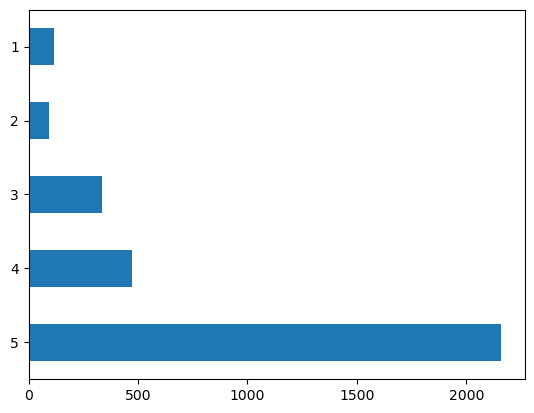

In [7]:
data.overall.value_counts().sort_index(ascending=False).plot(kind='barh')

## Количество уникальных товаров

In [8]:
data.asin.drop_duplicates().count()

31

## Количество уникальных пользователей

In [9]:
data.reviewerID.drop_duplicates().count()

406

In [10]:
def train_test_split(X, user_col, time_col):
  full_history = X.sort_values([user_col, time_col]).groupby(user_col)
  test = full_history.tail(1)
  train = full_history.head(-1)
  return train, test

In [11]:
train, test = train_test_split(data, 'reviewerID', 'reviewTime')

In [12]:
train.shape

(2770, 12)

In [13]:
test.shape

(406, 12)

In [14]:
overall = list(train.overall)

rows = train.reviewerID.astype('category').cat.codes
cols = train.asin.astype('category').cat.codes

train_sparse = sparse.csr_matrix((overall, (rows, cols)), shape=(train.reviewerID.nunique(), train.asin.nunique()))

In [15]:
train_sparse

<406x25 sparse matrix of type '<class 'numpy.intc'>'
	with 2658 stored elements in Compressed Sparse Row format>

In [16]:
matrix_size = train_sparse.shape[0]*train_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

73.8128078817734

In [17]:
train_sparse.shape

(406, 25)

# Метрики

In [ ]:
def mrr(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    mrr_values = []
    for _, row in df.iterrows():
      try:
        user_mrr = 1 / (row[pred_col].index(row[true_col]) + 1)
      except ValueError:
        user_mrr = 0
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

def hr(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    hr_values = []
    for _, row in df.iterrows():
      hr_values.append(int(row[true_col] in row[pred_col]))
    return np.mean(hr_values)

def ndcg(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    # ideal dcg == 1 при стратегии разделения leave-one-out
    ndcg_values = []
    for _, row in df.iterrows():
      try:
        user_ndcg = 1 / np.log2(row[pred_col].index(row[true_col]) + 2)
      except ValueError:
        user_ndcg = 0
      ndcg_values.append(user_ndcg)
    return np.mean(ndcg_values)

def coverage(train_df: pd.DataFrame, pred_df: pd.DataFrame, item_id='item_id', pred_col='preds') -> float:
    total_items_num = train_df[item_id].nunique()
    pred_items_num = len(set.union(*pred_df[pred_col].map(lambda x: set(x))))
    return pred_items_num / total_items_num

def calculate_metrics(train_df: pd.DataFrame, pred_df: pd.DataFrame, item_id='item_id', pred_col='preds', true_col='true'):
    print(f'mrr = {mrr(pred_df, true_col=true_col)}')
    print(f'hr = {hr(pred_df, true_col=true_col)}')
    print(f'ndcg = {ndcg(pred_df, true_col=true_col)}')
    print(f'coverage = {coverage(train_df, pred_df, item_id=item_id)}')

# Популярные товары

In [37]:
k = 10
count_items = Counter(train.asin)
count_items = [*count_items.items()]
count_items.sort(key=lambda x: x[1], reverse=True)

In [38]:
pred_items = [k for k, v in count_items[:k]]

In [39]:
pred = test.copy()
pred['preds'] = [pred_items] * len(pred)

In [40]:
calculate_metrics(train, pred, item_id='asin', true_col='asin')

mrr = 0.10358706701071234
hr = 0.9334975369458128
ndcg = 0.27882111400540355
coverage = 0.4


# userKNN

In [52]:
k_neighb = 5
test = test[test['overall'] == 5]

In [53]:
# маппинг id в индексы
def get_mapping(train_data):
    user_ids = sorted(train_data['reviewerID'].unique().tolist())
    item_ids = sorted(train_data['asin'].unique().tolist())

    n_users = len(user_ids)
    n_items = len(item_ids)

    user_idx = range(n_users)
    item_idx = range(n_items)

    user_mapping = dict(zip(user_ids, user_idx)) # {user_id: user_ind}
    item_mapping = dict(zip(item_ids, item_idx)) # {item_id: item_ind}
    return user_mapping, item_mapping

In [54]:
def userKNN(train_data, test_data, k_neighb, k):
    user_mapping, item_mapping = get_mapping(train_data)
    train_data['reviewerID'] = train_data['reviewerID'].map(user_mapping)
    test_data['reviewerID'] = test_data['reviewerID'].map(user_mapping)

    R = pd.pivot_table(train_data, values='overall', index='reviewerID', columns='asin', fill_value=0) # shape = n_users * n_items
    user_sim = cosine_similarity(R) # shape = n_users * n_users
    preds = []
    for _, row in tqdm_notebook(test_data.iterrows()):
        user = int(row['reviewerID'])
        neighb_inds = np.argsort(user_sim[user])[::-1][1: k_neighb + 1]
        neighb_sim = np.sort(user_sim[user])[::-1][1: k_neighb + 1]

        sum_ratings = (R.iloc[neighb_inds] * neighb_sim.reshape(k_neighb, -1)).sum(axis=0)
        sum_sim = (R.iloc[neighb_inds].astype(bool) * neighb_sim.reshape(k_neighb, -1)).sum(axis=0)

        user_ratings = sum_ratings / (sum_sim + 1e-10)
        user_ratings = pd.DataFrame(user_ratings, columns=['pred']).reset_index()
        user_ratings.sort_values(by=['pred'], ascending=False, inplace=True)
        preds.append(user_ratings['asin'][:k].tolist())

    test_data['preds'] = preds
    return test_data

In [55]:
pred = userKNN(train, test, k_neighb, k)

0it [00:00, ?it/s]

In [56]:
calculate_metrics(train, pred, item_id='asin', true_col='asin')

mrr = 0.042182685039827895
hr = 0.08058608058608059
ndcg = 0.05054693341806657
coverage = 0.92


# itemKNN

In [57]:
def itemKNN(train_data, test_data, k_neighb, k):
    user_mapping, item_mapping = get_mapping(train_data)
    train_data['reviewerID'] = train_data['reviewerID'].map(user_mapping)
    test_data['reviewerID'] = test_data['reviewerID'].map(user_mapping)
    train_data['asin'] = train_data['asin'].map(item_mapping)
    test_data['asin'] = test_data['asin'].map(item_mapping)

    R = pd.pivot_table(train_data, values='overall', index='reviewerID', columns='asin', fill_value=0) # shape = n_users * n_items
    item_sim = cosine_similarity(R.T) # shape = n_items * n_items
    preds = []
    for _, row in tqdm_notebook(test_data.iterrows()):
        user = row['reviewerID']
        user_interactions = train_data[train_data['reviewerID'] == user]
        user_interactions = user_interactions[user_interactions['overall'] == 5]

        item_preds = pd.DataFrame()
        for _, row in user_interactions.iterrows():
            item = row['asin']
            neighb_inds = np.argsort(item_sim[item])[::-1][1: k_neighb + 1]
            neighb_sim = np.sort(item_sim[item])[::-1][1: k_neighb + 1]

            sum_ratings = (R.T.iloc[neighb_inds] * neighb_sim.reshape(k_neighb, -1)).sum(axis=1)
            sum_sim = (R.T.iloc[neighb_inds].astype(bool) * neighb_sim.reshape(k_neighb, -1)).sum(axis=1)

            item_ratings = sum_ratings / (sum_sim + 1e-10)
            item_ratings = pd.DataFrame(item_ratings, columns=['pred']).reset_index()

            item_preds = pd.concat([item_preds, item_ratings])

        item_preds.sort_values(by=['pred'], ascending=False, inplace=True)
        preds.append(item_preds['asin'][:k].tolist())

    test_data['preds'] = preds
    return test_data

In [58]:
calculate_metrics(train, pred, item_id='asin', true_col='asin')

mrr = 0.042182685039827895
hr = 0.08058608058608059
ndcg = 0.05054693341806657
coverage = 0.92


# ALS

In [60]:
train, test = train_test_split(data, 'reviewerID', 'reviewTime')

In [18]:
import implicit
algo = implicit.als.AlternatingLeastSquares(factors = 16, regularization = 0.1, iterations =50, use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
user_vecs = algo.user_factors
item_vecs = algo.item_factors
# проверим по размерам, что мы действиельно не перепутали users и items
print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(406, 25)
(406, 16) (25, 16)


In [20]:
user_vecs.dot(item_vecs.T).shape

(406, 25)

In [21]:
def predict(user_vecs, item_vecs, rating_matrix=None, filter_seen=False, k=10):
    id2user = dict(zip(rows, train.reviewerID))
    id2item = dict(zip(cols, train.asin))

    scores = user_vecs.dot(item_vecs.T)
    if filter_seen:
        scores = np.multiply(
            scores,
            np.invert(rating_matrix.todense().astype(bool))
            )

    preds = pd.DataFrame(columns = ['reviewerID',	'preds'])

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    preds = pd.DataFrame({
        'reviewerID': range(user_vecs.shape[0]),
        'preds': np.flip(indices, axis=1).tolist(),
        })
    preds['reviewerID'] = preds['reviewerID'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [22]:
pred = predict(user_vecs, item_vecs, train_sparse, filter_seen=True)
pred = pred.merge(test, how='left', on='reviewerID')

In [35]:
calculate_metrics(train, pred, item_id='asin', true_col='asin')

mrr = 0.6548977637031823
hr = 0.8694581280788177
ndcg = 0.7048602301755226
coverage = 1.0


# Выводы
* Бейзлайн на популярных товарах показал высокую метрику hr, то есть популярные товары довольно часто покупают
* Модели колаборативной фильтрации показали довольно низкие значения метрик, то есть прогноз хуже, чем у бейзлайна. Однако, метрика coverage довольно высокая, то есть в рекомендации попадает большое число товаров
* Модель ALS показала высокие значения всех метрик, то есть прогноз самый лучший